# Do interface design to further filter out unproductive designs prior to looping

In [30]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

sys.path.insert(0, "/home/broerman/projects/crispy_shifty")

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
running in directory: /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling
running on node: sofia


In [7]:
import pyrosetta.distributed.cluster as cluster

allowed_parents = ['DHR39', 'DHR62', 'DHR82']
parent_counts = {'DHR39': 0, 'DHR62': 0, 'DHR82': 0}

states_file = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/01_make_states/states.list"
states_sample_file = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/01_make_states/states_sample.list"
with open(states_file, "r") as f:
    with open(states_sample_file, 'w') as f_sample:
        for line in f:
            parent = cluster.get_scores_dict(line.rstrip())["scores"]['parent']
            if parent in allowed_parents:
                f_sample.write(line)
                parent_counts[parent] += 1
print(parent_counts)

{'DHR39': 16, 'DHR62': 12, 'DHR82': 12}


In [2]:
# I had about 10 samples per design last round, and it was not enough. So, kick sampling up an order of magnitude.

from crispy_shifty.utils.io import gen_array_tasks

design_list_file = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/01_make_states/states_sample.list"
output_path = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter"

# Format as a string of key value pairs with no leading dashes on the argument names
options = "out:level 100 holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5 precompute_ig true"

gen_array_tasks(distribute_func='crispy_shifty.protocols.design.one_state_design_unlooped_dimer',
                design_list_file=design_list_file,
                output_path=output_path,
                queue='backfill',
                memory='13G',
                nstruct=100,
                options=options,
                simulation_name='02_design_filter')

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Run the following command with your desired environment active:
sbatch -a 1-$(cat /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/tasks.cmds | wc -l) /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/run.sh


In [23]:
!sjobs -J 65432354 > 02_design_filter/backfill_jobs.json

In [24]:
jobs_df = pd.read_json('02_design_filter/backfill_jobs.json')
jobs_df

,JobID,Step,Task,JobName,Start,Wait,Partition,User,Elapsed,NNodes,NCPUS,UserCPU,pCPU,ReqMem,MemUsed,pMem,State
0,65432354,NaN,1,02_design_filter,1639077860,1,backfill,broerman,8965,1,1,87.83,NaN,12582912,10341284,82.185141,COMPLETED
1,65432354,NaN,2,02_design_filter,1639144209,4967,backfill,broerman,8631,1,1,85.8,NaN,12582912,10397028,82.628155,COMPLETED
2,65432354,NaN,3,02_design_filter,1639077860,1,backfill,broerman,8337,1,1,79.47,NaN,12582912,10300236,81.858921,COMPLETED
3,65432354,NaN,4,02_design_filter,1639143853,5729,backfill,broerman,11577,1,1,114.44,NaN,12582912,3760,0.029882,COMPLETED
4,65432354,NaN,5,02_design_filter,1639077860,1,backfill,broerman,9412,1,1,92.3,NaN,12582912,10928920,86.855253,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,65432354,NaN,3996,02_design_filter,1639113303,218,backfill,broerman,9849,1,1,97.5,NaN,13631488,9446428,69.298583,COMPLETED
3996,65432354,NaN,3997,02_design_filter,1639117078,554,backfill,broerman,8873,1,1,87.82,NaN,13631488,9273668,68.031223,COMPLETED
3997,65432354,NaN,3998,02_design_filter,1639133609,157,backfill,broerman,10720,1,1,139.34,NaN,13631488,11054016,81.091778,COMPLETED
3998,65432354,NaN,3999,02_design_filter,1639087339,9480,backfill,broerman,8694,1,1,86.09,NaN,13631488,7972040,58.482537,COMPLETED


In [26]:
failed_jobs_df = jobs_df[jobs_df['State'] != 'COMPLETED']
failed_jobs_df

,JobID,Step,Task,JobName,Start,Wait,Partition,User,Elapsed,NNodes,NCPUS,UserCPU,pCPU,ReqMem,MemUsed,pMem,State
9,65432354,NaN,10,02_design_filter,1639107042,20979,backfill,broerman,407,1,1,06:03.043,NaN,12582912,5306680,42.173704,OUT_OF_MEMORY
88,65432354,NaN,89,02_design_filter,1639087842,127,backfill,broerman,582,1,1,08:24.013,NaN,12582912,12025300,95.568498,CANCELLED
90,65432354,NaN,91,02_design_filter,1639087861,146,backfill,broerman,43213,1,1,,NaN,12582912,66852,0.531292,CANCELLED
129,65432354,NaN,130,02_design_filter,1639077863,4,backfill,broerman,440,1,1,05:48.898,NaN,12582912,4885516,38.826593,OUT_OF_MEMORY
130,65432354,NaN,131,02_design_filter,1639109566,235,backfill,broerman,1190,1,1,18:21.007,NaN,12582912,11630404,92.430147,CANCELLED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940,65432354,NaN,3941,02_design_filter,1639087162,9303,backfill,broerman,1262,1,1,19:23.012,NaN,13631488,8210344,60.230725,CANCELLED
3947,65432354,NaN,3948,02_design_filter,1639108395,20821,backfill,broerman,2358,1,1,38:19.023,NaN,13631488,6620376,48.566789,CANCELLED
3958,65432354,NaN,3959,02_design_filter,1639087177,9318,backfill,broerman,1247,1,1,19:24.014,NaN,13631488,7158400,52.513709,CANCELLED
3972,65432354,NaN,3973,02_design_filter,1639087254,9395,backfill,broerman,969,1,1,00:00.572,NaN,13631488,66852,0.490423,FAILED


In [29]:
os.rename('02_design_filter/tasks.cmds', '02_design_filter/old_tasks.cmds')
with open('02_design_filter/old_tasks.cmds', 'r') as f:
    tasks = f.readlines()
with open('02_design_filter/tasks.cmds', 'w') as f_new:
    for task_ind in failed_jobs_df['Task']:
        f_new.write(tasks[task_ind])

In [31]:
from crispy_shifty.utils.io import collect_score_file
output_path = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter"
collect_score_file(output_path, 'scores')

In [32]:
# Now that I've sufficiently sampled most of the inputs, read the new final scorefiles and filter

def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores

scores_path = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/scores.json'
scores_df = read_scorefile(scores_path)

scores_df

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,shift_A,shift_B,ss_sc,total_score,wnm_1,wnm_2,wnm_3,wnm_4,wnm_hlx,yhh_planarity
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0000/02_design_filter_a54bd978c812418da0ba146e0b965fa7.pdb.bz2,2475.162353515625,196.38331604003906,48.638671875,-1.0,398.373779296875,576.1590576171875,416.4674072265625,30.0,22.0,15.0,...,-5.0,1.0,0.7336503276381101,29735.400726714302,0.44029189703693306,0.3944093989386412,0.36285958216177633,0.33948237023466715,0.10725229341625282,0.0
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0000/02_design_filter_c09fad5a1c494c93acf5edf27fa8a6b7.pdb.bz2,3117.333740234375,52.073272705078125,3065.260498046875,-1.0,411.2391662597656,766.5045166015625,538.578125,36.0,33.0,17.0,...,1.0,2.0,0.7472699503654924,39462.50286108706,0.1809360309507397,0.16196228160148315,0.2054376427582002,0.2508940695516781,0.12325630167470253,0.0
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0000/02_design_filter_de1e989fe3374324a31b430ecc5a238a.pdb.bz2,104.14654541015625,52.073272705078125,52.073272705078125,-1.0,424.6455993652344,759.196533203125,535.1472778320312,36.0,17.0,17.0,...,1.0,6.0,0.7494071090166365,19909.046279313574,0.22350676552961607,0.21718683833712632,0.18261504420212923,0.177384412807533,0.1299098688257658,0.0
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0000/02_design_filter_0b0dc0baadc243d69b2f4392032f7378.pdb.bz2,2297.524169921875,196.38331604003906,48.638668060302734,-1.0,417.8218994140625,591.3742065429688,422.5541076660156,30.0,22.0,15.0,...,-5.0,1.0,0.7246913178908865,29772.233036908237,0.4906613595810084,0.4119844908912397,0.4804640845396657,0.2995564735086446,0.11981258480849427,0.0
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0000/02_design_filter_e90ce8457a254ef7ad18c3b5628c94aa.pdb.bz2,1765.297119140625,52.073272705078125,1713.2237548828125,-1.0,456.7383728027344,689.0709838867188,605.0570678710938,39.0,33.0,17.0,...,1.0,2.0,0.7365645785779701,43482.87994016218,0.18769204600126438,0.22483407206928152,0.17572556710531503,0.21312378163148898,0.1065953351851712,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0002/02_design_filter_d9ac4cf044694cd0acc7ed5d7780a57f.pdb.bz2,104.14654541015625,52.073272705078125,52.073272705078125,-1.0,381.83270263671875,789.8916625976562,541.2528686523438,36.0,26.0,17.0,...,1.0,-1.0,0.7359255232717222,22017.543278257206,0.21475472853442323,0.2195478942811728,0.1693572643267115,0.2199470819769531,0.10482426401553671,0.0
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0002/02_design_filter_9e34832c345b40cbbcafac90c700e95c.pdb.bz2,104.14654541015625,52.073272705078125,52.073272705078125,-1.0,407.08441162109375,753.5518798828125,528.9310913085938,39.0,17.0,17.0,...,1.0,6.0,0.7345294678523131,24249.61863952516,0.19001634801045394,0.2071263658907158,0.20062334353471512,0.2012390444143017,0.09566806408184923,0.0
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0002/02_design_filter_ee09097e919741b0b928f718317f03ef.pdb.bz2,195.81900024414062,48.664005279541016,48.715911865234375,30.378559112548828,450.3384094238281,465.2308654785156,576.9025268554688,19.0,22.0,15.0,...,2.0,-6.0,0.7099408653066779,13827.642849260845,0.37342279480058865,0.33106481481798966,0.39183442933330137,0.3498952495447237,0.09614699055272619,0.0
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filte

In [33]:
scores_df['parent'].nunique()

3

In [34]:
# Compute derivative scores

scores_df['de_1_4'] = scores_df['score_14'].astype(float) - scores_df['score_1'].astype(float) - scores_df['score_4'].astype(float)
scores_df['de_14_2'] = scores_df['score_124'].astype(float) - scores_df['score_14'].astype(float) - scores_df['score_2'].astype(float)
scores_df['de_14_3'] = scores_df['score_134'].astype(float) - scores_df['score_14'].astype(float) - scores_df['score_3'].astype(float)
scores_df['de_2_3'] = scores_df['score_23'].astype(float) - scores_df['score_2'].astype(float) - scores_df['score_3'].astype(float)
scores_df['wnm'] = scores_df[['wnm_1', 'wnm_2', 'wnm_3', 'wnm_4']].max(axis=1)
scores_df['delta_loop_dist_A'] = scores_df['loop_dist_A'].astype(float) - scores_df['parent_loop_dist'].astype(float)
scores_df['delta_loop_dist_B'] = scores_df['loop_dist_B'].astype(float) - scores_df['parent_loop_dist'].astype(float)

22it [00:02, 10.97it/s]


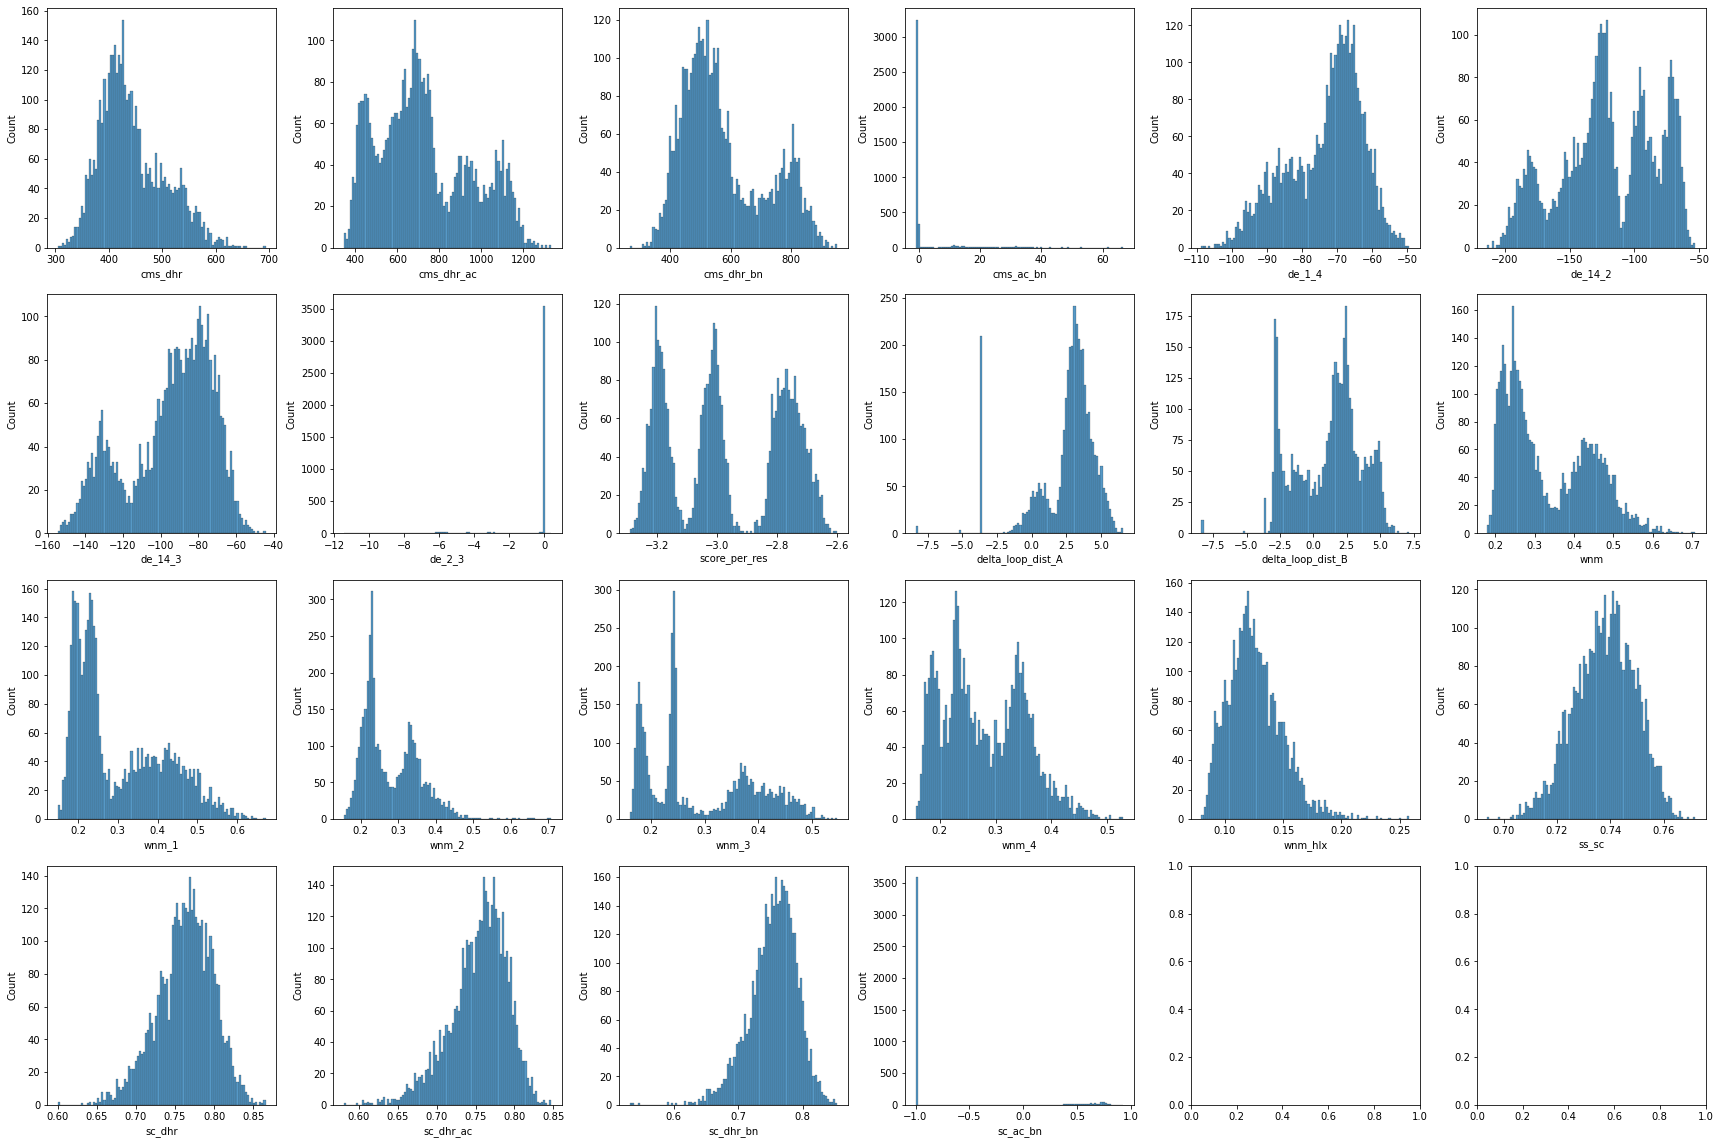

In [35]:
import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.plotting.utils import histplot_df

cols = [
        "cms_dhr",
        "cms_dhr_ac",
        "cms_dhr_bn",
        "cms_ac_bn",
        "de_1_4",
        "de_14_2",
        "de_14_3",
        "de_2_3",
        "score_per_res",
        "delta_loop_dist_A",
        "delta_loop_dist_B",
        "wnm",
        "wnm_1",
        "wnm_2",
        "wnm_3",
        "wnm_4",
        "wnm_hlx",
        "ss_sc",
        "sc_dhr",
        "sc_dhr_ac",
        "sc_dhr_bn",
        "sc_ac_bn"
    #     "parent",
    ]

# make sure all the columns to plot are numeric
scores_df[cols] = scores_df[cols].astype(float)
histplot_df(scores_df, cols=cols, bins=100)

22it [00:05,  4.30it/s]


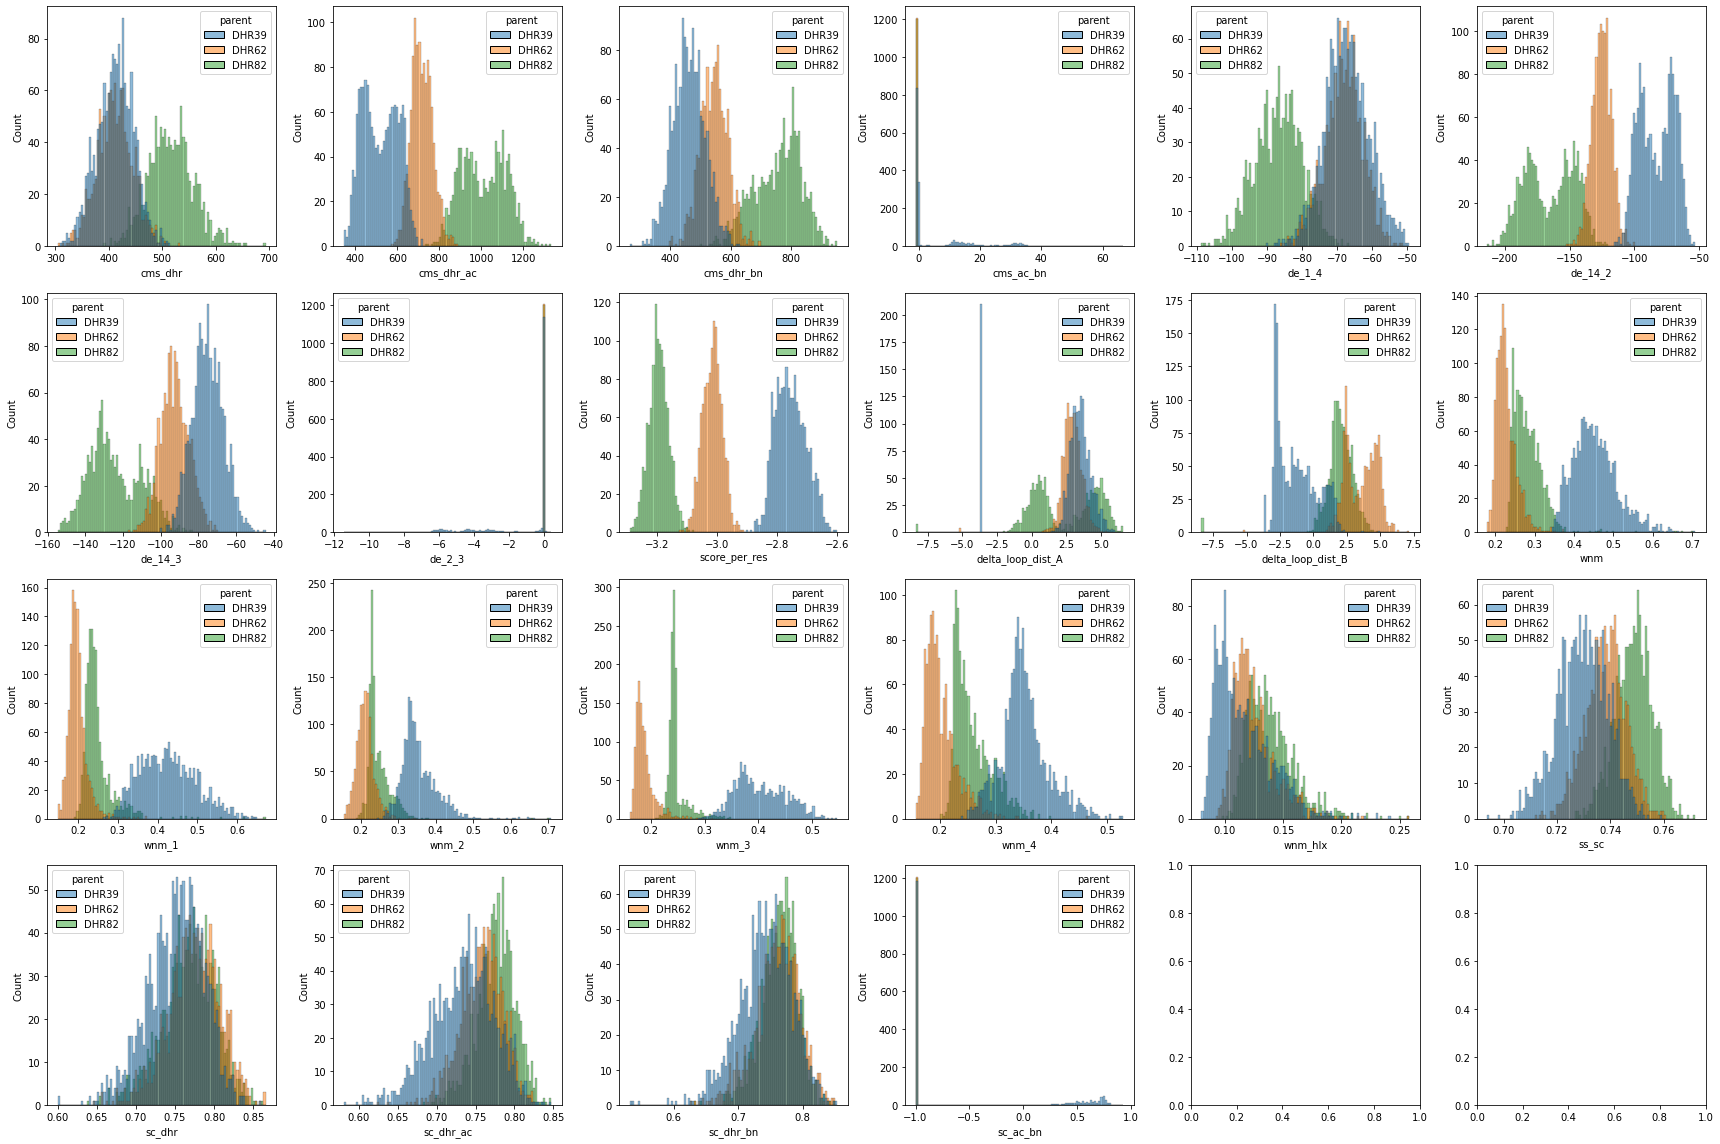

In [47]:
histplot_df(scores_df, cols=cols, bins=100, hue='parent', hue_order=('DHR39', 'DHR62', 'DHR82'))

In [48]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

def filter_df_delta(df, parent_df, delta_cutoffs):
    filtered_df = df

    for score_term, parent_term, cutoff, greaterthan in delta_cutoffs:
        filtered_series = filtered_df[score_term]
        parent_scores = parent_df.loc[filtered_df['parent'], parent_term]
        parent_scores.index = filtered_series.index
        # print(filtered_series)
        # print(parent_scores)
        # print(parent_scores - filtered_series < cutoff)
        if greaterthan:
            filtered_df = filtered_df[filtered_series - parent_scores > -cutoff]
        else:
            filtered_df = filtered_df[filtered_series - parent_scores < cutoff]
    
    print(len(filtered_df))
    
    return filtered_df

In [49]:
# Filter designs- remove worst by worst9mer and whether the designs have terrible shape complementarity

cutoffs = [('ss_sc', 0.7, 1),
           ('sc_dhr', 0.65, 1),
           ('sc_dhr_ac', 0.65, 1),
           ('sc_dhr_bn', 0.65, 1),
           ('wnm', 0.5, 0),
           ('wnm_hlx', 0.17, 0)
]

filtered_df = filter_df(scores_df, cutoffs)

3494


In [46]:
parent_scores = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/00_inputs/scaffold_scores.json'
parent_df = read_scorefile(parent_scores)
parent_df.set_index('name', inplace=True) # replaces the indexing by path to indexing by name
from IPython.display import display
with pd.option_context('display.max_columns', None):
    display(parent_df.loc[('DHR39', 'DHR62', 'DHR82'), :])

,cms_dhr,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,hxl_tors,lk_ball,lk_ball_bridge,lk_ball_bridge_uncpl,lk_ball_iso,loop_dist,omega,p_aa_pp,pro_close,rama_prepro,ref,sc_dhr,score,score_1,score_12,score_2,score_per_res,ss_sc,total_score,wnm_1,wnm_2,wnm_hlx
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DHR39,321.138519,0.0,-1021.834993,17.066784,143.013018,193.845212,-399.394071,-59.330212,-31.171610,63.490618,49.433098,229.582809,884.115289,-7.475937,-9.414611,-68.834158,-151.370120,25.415406,541.281267,0.989265,8.139941,1221.825963,7.445681,39.944409,-61.277284,0.043679,79.400406,-80.529978,0.609407,-385.315033,-170.901306,-385.315033,-169.123169,-2.335243,0.731973,-385.315035,0.377876,0.327590,0.085988
DHR62,341.227570,0.0,-1053.675136,11.760569,124.949169,198.744984,-426.274689,-53.872070,-38.808156,41.258391,49.554598,235.666034,890.531219,-8.693967,-6.716731,-55.414077,-164.472197,11.904063,574.155874,1.258139,9.201718,1302.062905,8.931612,45.641537,-50.595302,0.000000,16.729926,-20.508228,0.699454,-436.642181,-196.503754,-436.642181,-190.431580,-2.568483,0.724543,-436.642174,0.198498,0.198388,0.097031
DHR82,521.558899,0.0,-1498.559091,21.318266,188.024945,262.872950,-583.674273,-79.204600,-40.859747,99.079365,65.163691,335.720796,1233.036110,-11.329700,-7.510758,-68.194081,-228.294489,31.438217,789.137781,1.765028,13.765930,1779.659698,12.176095,57.026854,-67.175665,0.216008,81.972807,-107.705382,0.726814,-621.641541,-269.689850,-621.641541,-283.966553,-2.726498,0.744233,-621.641546,0.226993,0.237057,0.110452


8it [00:01,  4.91it/s]


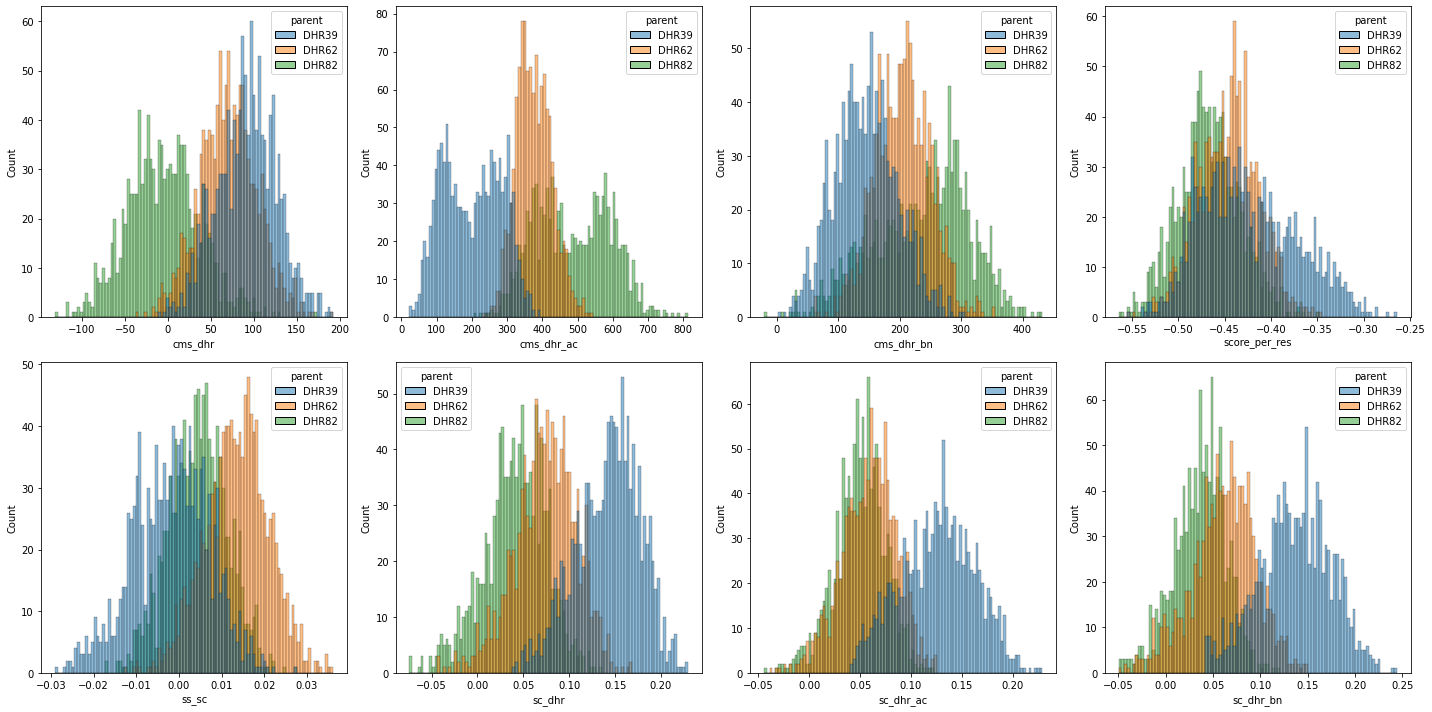

In [50]:
# Plots distributions of delta scores between the parent and the children.
# Delta scores are calculated by design_value - parent_value.
# For scores which I'm trying to maximize, higher delta values are better.
# Conclusion: all score_per_res are better than the parents, and sc and cms usually increase, even for the side domains!
# Only cms_dhr decreases significantly from the parent.
# So, let's just filter based on whether designs are as good as or better than the parent (cutoffs at 0).

delta_pairs = [('cms_dhr', 'cms_dhr'),
               ('cms_dhr_ac', 'cms_dhr'),
               ('cms_dhr_bn', 'cms_dhr'),
               ('score_per_res', 'score_per_res'),
               ('ss_sc', 'ss_sc'),
               ('sc_dhr', 'sc_dhr'),
               ('sc_dhr_ac', 'sc_dhr'),
               ('sc_dhr_bn', 'sc_dhr')]

score_terms, parent_terms = tuple(map(list, zip(*delta_pairs)))
# gets the columns to filter on from the parent df, then duplicate rows by parent such that rows correspond to the parents of the rows of filtered df
parent_aligned_df = parent_df[parent_terms].loc[filtered_df['parent'], :]
parent_aligned_df.index = filtered_df.index
parent_aligned_df.columns = score_terms # fixes an issue with duplicate column names, and makes sure the output columns are correctly named
delta_df = filtered_df[score_terms] - parent_aligned_df
delta_df['parent'] = filtered_df['parent']

fig, axs = plt.subplots(2, 4, figsize=(20,10))

for col, ax in tqdm(zip(score_terms, axs.flatten())):
    sns.histplot(
        data=delta_df,
        x=col,
        ax=ax,
#         kde=True,
        hue='parent',
        hue_order=('DHR39', 'DHR62', 'DHR82'),
        bins=100
    )

plt.tight_layout()

In [15]:
# how do I determine these cutoffs? Look at distributions of delta cutoffs between the parent and the children

# These are the old cutoffs I used. Honestly, I don't feel like it's necessary to filter based on delta cutoffs here... These scores are already great!
# So I don't actually run this cell. The below code is old from the first run.

# here, "cutoff" means "if the design scores worse than the parent by x"
delta_cutoffs = [('cms_dhr', 'cms_dhr', 100, 1),
                 ('cms_dhr_ac', 'cms_dhr', 0, 1),
                 ('cms_dhr_bn', 'cms_dhr', 0, 1),
                 ('score_per_res', 'score_per_res', 0.2, 0),
                 ('ss_sc', 'ss_sc', 0, 1),
                 ('sc_dhr', 'sc_dhr', 0, 1),
                 ('sc_dhr_ac', 'sc_dhr', 0, 1),
                 ('sc_dhr_bn', 'sc_dhr', 0, 1)]

delta_filtered_df = filter_df_delta(filtered_df, parent_df, delta_cutoffs)

5980


In [51]:
filtered_json_path = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/filtered_designs.json'
filtered_df.to_json(filtered_json_path)
filtered_list_path = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/filtered_designs.list'
with open(filtered_list_path, 'w') as f:
    f.write('\n'.join(filtered_df.index))

In [52]:
# print 50 random designs to load into pymol, just to check that everything looks good.
print(';'.join('load ' + path for path in filtered_df.sample(50).index))

# Overall, these all look great!

load /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0000/02_design_filter_5662022ecc6e45a39c077d89ff9f05e3.pdb.bz2;load /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0003/02_design_filter_2eb922e216074ca3a28dc8c5cbd95383.pdb.bz2;load /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0002/02_design_filter_7591e0e6586a428892611e651295dff9.pdb.bz2;load /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0002/02_design_filter_46a22a8963734feea185ac09dba46dd2.pdb.bz2;load /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0003/02_design_filter_e3c6aadc1bd1477b91306f136f673246.pdb.bz2;load /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/decoys/0002/02_design_filt